In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/03-what-is-data/VADER-what-is-data.csv')

In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,"{'language': 'en', 'score': 0.9999957253533018}",en,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.8999,pos
1,1,2021-03-11,Greate Course,5,completer,13,pos,"{'language': 'en', 'score': 0.999994475073214}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
2,2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,"{'language': 'en', 'score': 0.9999964991174284}",en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neu
3,3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,"{'language': 'en', 'score': 0.9999949953681738}",en,"{'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...",0.6249,pos
4,4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,"{'language': 'en', 'score': 0.9999963070938086}",en,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",0.2263,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,0.8999,pos
1,2021-03-11,Greate Course,5,completer,13,pos,0.0000,neu
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,0.0000,neu
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,0.6249,pos
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,0.2263,pos
...,...,...,...,...,...,...,...,...
7869,2018-08-28,Thanks for the data science introduction!,5,dropout,42,pos,0.4926,pos
7870,2018-08-28,Some very interesting materials in the form of...,5,dropout,72,pos,0.6240,pos
7871,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104,pos,0.8655,pos
7872,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96,pos,0.4404,pos


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

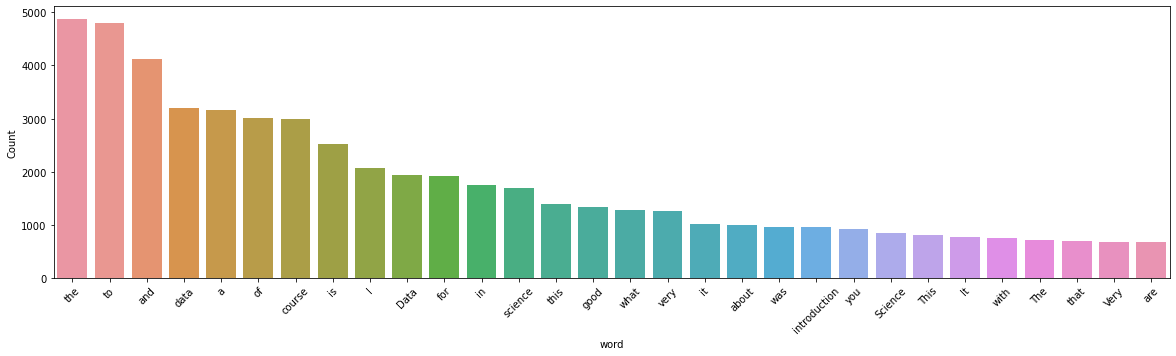

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [13]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    this course has a good overview of data scienc...
1                                        greate course
2    have an overall understanding of data science ...
3          course creates interest to keep on learning
4    even though i have been self-teaching for abou...
Name: preprocessed, dtype: object

In [14]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    this course has a good overview of data scienc...
1                                        greate course
2    have an overall understanding of data science ...
3          course creates interest to keep on learning
4    even though i have been selfteaching for about...
Name: preprocessed, dtype: object

In [15]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'one', 'would', 'could', 'thank', 'thanks'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    course overview data science related concepts ...
1                                        greate course
2      overall understanding data science future looks
3                course creates interest keep learning
4    even though selfteaching year surprised much l...
Name: preprocessed, dtype: object

In [16]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed
19,2021-03-05,nice,5,completer,4,pos,0.4215,pos,
21,2021-03-05,good,5,completer,4,pos,0.4404,pos,
23,2021-03-05,Very good,5,completer,9,pos,0.4927,pos,
83,2021-02-22,Good,5,completer,5,pos,0.4404,pos,
130,2021-02-13,great!,5,completer,6,pos,0.6588,pos,
...,...,...,...,...,...,...,...,...,...
7449,2018-12-08,Very good,5,completer,9,pos,0.4927,pos,
7497,2018-11-20,nice,5,dropout,4,pos,0.4215,pos,
7508,2018-11-17,good,4,completer,4,pos,0.4404,pos,
7546,2018-11-07,Nice,5,completer,4,pos,0.4215,pos,


In [17]:
df = df[(df['preprocessed']!= "")]

In [18]:
# Reset the index

df = df.reset_index(drop = True)

In [19]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

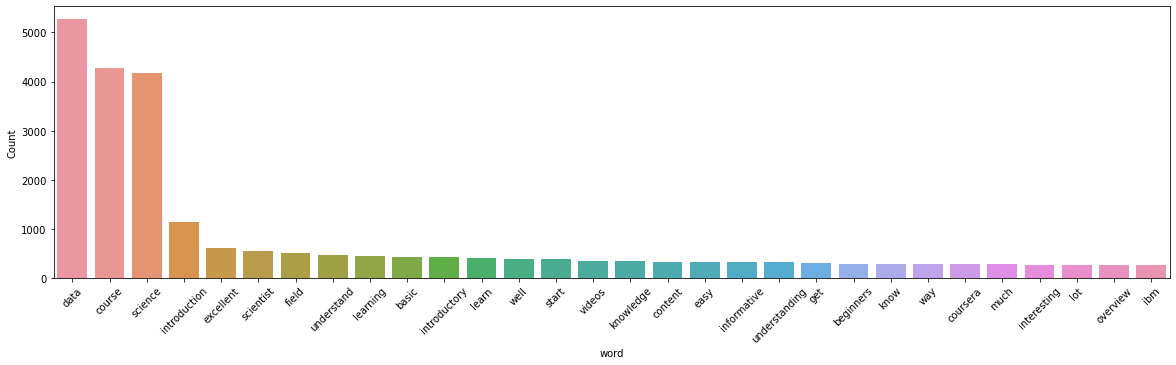

In [20]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [21]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, overview, data, science, related, con...
1                                     [greate, course]
2    [overall, understanding, data, science, future...
3          [course, creates, interest, keep, learning]
4    [even, though, selfteaching, year, surprised, ...
Name: preprocessed, dtype: object

In [22]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (overview, NN), (data, NNS), (s...
1                         [(greate, NN), (course, NN)]
2    [(overall, JJ), (understanding, NN), (data, NN...
3    [(course, NN), (creates, VBZ), (interest, NN),...
4    [(even, RB), (though, IN), (selfteaching, VBG)...
Name: preprocessed, dtype: object

In [23]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (overview, n), (data, n), (scien...
1                           [(greate, n), (course, n)]
2    [(overall, a), (understanding, n), (data, n), ...
3    [(course, n), (creates, v), (interest, n), (ke...
4    [(even, r), (though, n), (selfteaching, v), (y...
Name: preprocessed, dtype: object

In [25]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, overview, data, science, relate, conc...
1                                     [greate, course]
2    [overall, understanding, data, science, future...
3           [course, create, interest, keep, learning]
4    [even, though, selfteaching, year, surprise, m...
Name: preprocessed, dtype: object

In [26]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

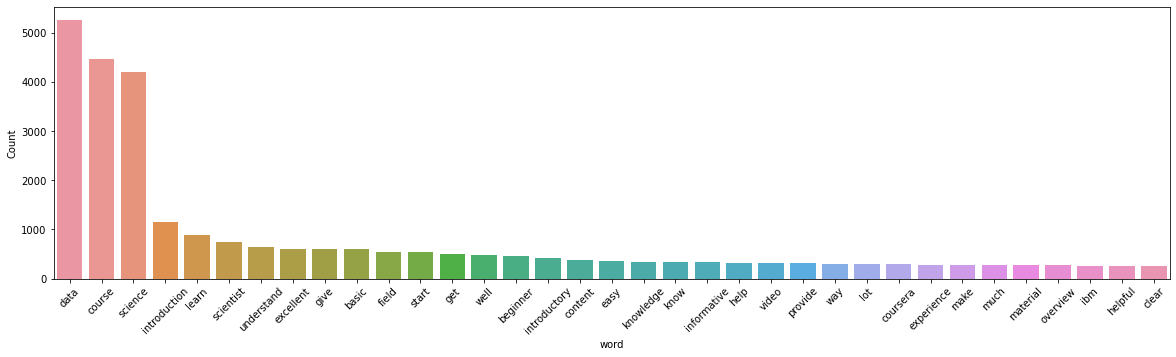

In [27]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [28]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [29]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [30]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [31]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [32]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 3, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.25)

In [33]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: Technologies or course delivery, Topic 1: Content, Topic 2: Learner experience')

Topic: 0
Word: 0.032*"course" + 0.015*"video" + 0.013*"easy" + 0.013*"content" + 0.011*"material" + 0.008*"much" + 0.008*"read" + 0.007*"well" + 0.007*"videos" + 0.007*"time"

Topic: 1
Word: 0.140*"data" + 0.108*"science" + 0.040*"course" + 0.037*"introduction" + 0.024*"scientist" + 0.017*"give" + 0.016*"field" + 0.013*"understand" + 0.009*"overview" + 0.008*"basic"

Topic: 2
Word: 0.125*"course" + 0.041*"data" + 0.040*"science" + 0.031*"learn" + 0.023*"excellent" + 0.020*"beginner" + 0.017*"basic" + 0.016*"introductory" + 0.016*"start" + 0.013*"coursera"

Topic 0: Technologies or course delivery, Topic 1: Content, Topic 2: Learner experience


### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.129137  0.112975       1        1  44.834711
2     -0.082330 -0.130974       2        1  27.787182
0      0.211467  0.017999       3        1  27.378108, topic_info=             Term         Freq        Total Category  logprob  loglift
8            data  4887.000000  4887.000000  Default  30.0000  30.0000
21        science  3907.000000  3907.000000  Default  29.0000  29.0000
7          course  4029.000000  4029.000000  Default  28.0000  28.0000
40   introduction  1156.000000  1156.000000  Default  27.0000  27.0000
72      scientist   695.000000   695.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
211          take    80.941231   219.761264   Topic3  -5.4036   0.2966
170    understand    84.587551   590.481558   Topic3  -5.3595  -0.6477
14            get    79.290790   476.165030   Topic3  -5.4242  -0.4972
33           even    63.328606   108.730700   Topic3  -5.6490   0.7549
130   information    66.608960   222.295988   Topic3  -5.5985   0.0903

[230 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
384       3  0.981253          1
385       3  0.987974          2
252       1  0.024866          3
252       3  0.944899          3
1290      3  0.948911          5
...     ...       ...        ...
447       2  0.801880  wonderful
78        1  0.906642      world
78        2  0.090664      world
78        3  0.005333      world
2060      2  0.965909          ã

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [35]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.251176150310227

Coherence Score:  0.45854037035656603


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [269]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [270]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

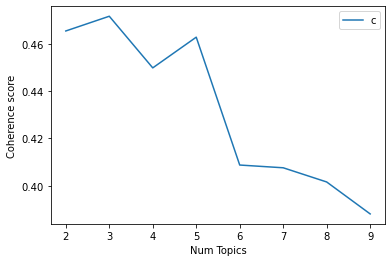

In [271]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [272]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4655
Num Topics = 3  has Coherence Value of 0.4718
Num Topics = 4  has Coherence Value of 0.4499
Num Topics = 5  has Coherence Value of 0.4629
Num Topics = 6  has Coherence Value of 0.4088
Num Topics = 7  has Coherence Value of 0.4076
Num Topics = 8  has Coherence Value of 0.4016
Num Topics = 9  has Coherence Value of 0.388


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [267]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [268]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('video', 0.029447059909535677),
   ('material', 0.025385396473737654),
   ('information', 0.022062217298993814),
   ('people', 0.020677559309517216),
   ('complete', 0.01689282747161451),
   ('time', 0.015600480014769685),
   ('student', 0.01375426936213422),
   ('read', 0.013292716698975353),
   ('question', 0.011908058709498754),
   ('quiz', 0.011077263915812794)]),
 (1,
  [('science', 0.1557513460597161),
   ('data', 0.12765540871267744),
   ('introduction', 0.0990699951052374),
   ('excellent', 0.059520313264806654),
   ('understand', 0.058541360744003915),
   ('basic', 0.05824767498776309),
   ('field', 0.052276064610866375),
   ('beginner', 0.04522760646108664),
   ('helpful', 0.024963289280469897),
   ('explain', 0.023299069995105236)]),
 (2,
  [('science', 0.11956413076077177),
   ('data', 0.08987303808857343),
   ('start', 0.05358392482255323),
   ('introductory', 0.03958812356293112),
   ('knowledge', 0.034089773068079574),
   ('coursera', 0.028791362591222634),
   (

In [434]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [435]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [436]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,0.8999,pos,"[course, overview, data, science, relate, conc...",course overview data science relate concept al...,"(1, 0.8647405)",1.0,0.864740
1,2021-03-11,Greate Course,5,completer,13,pos,0.0000,neu,"[greate, course]",greate course,"(2, 0.8143114)",2.0,0.814311
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,0.0000,neu,"[overall, understanding, data, science, future...",overall understanding data science future look,"(1, 0.92023826)",1.0,0.920238
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,0.6249,pos,"[course, create, interest, keep, learning]",course create interest keep learning,"(0, 0.90366244)",0.0,0.903662
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,0.2263,pos,"[even, though, selfteaching, year, surprise, m...",even though selfteaching year surprise much le...,"(0, 0.6859359)",0.0,0.685936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7636,2018-08-28,Thanks for the data science introduction!,5,dropout,42,pos,0.4926,pos,"[thanks, data, science, introduction]",thanks data science introduction,"(1, 0.7201225)",1.0,0.720123
7637,2018-08-28,Some very interesting materials in the form of...,5,dropout,72,pos,0.6240,pos,"[interesting, material, form, well, puttogethe...",interesting material form well puttogether video,"(0, 0.67606914)",0.0,0.676069
7638,2018-08-28,Very easy to understand. A perfect introductio...,5,dropout,104,pos,0.8655,pos,"[easy, understand, perfect, introduction, data...",easy understand perfect introduction data scie...,"(2, 0.57855624)",2.0,0.578556
7639,2018-08-25,"Was good learning spl, if you are looking to b...",5,completer,96,pos,0.4404,pos,"[learn, spl, look, build, anlaytics, skill, da...",learn spl look build anlaytics skill data science,"(1, 0.9405767)",1.0,0.940577


In [437]:
df_final = df.drop(['joined', 'topic'], axis = 1)

In [438]:
# Save dataframe as a csv file

df_final.to_csv('what-is-data-final.csv')

In [439]:
df_final.head(31)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,topic_id,topic_score
0,2021-03-11,This course has a good overview of data scienc...,5,completer,371,pos,0.8999,pos,"[course, overview, data, science, relate, conc...",1.0,0.864740
1,2021-03-11,Greate Course,5,completer,13,pos,0.0000,neu,"[greate, course]",2.0,0.814311
2,2021-03-10,have an overall understanding of data science ...,5,completer,70,pos,0.0000,neu,"[overall, understanding, data, science, future...",1.0,0.920238
3,2021-03-10,Course creates interest to keep on learning,4,completer,43,pos,0.6249,pos,"[course, create, interest, keep, learning]",0.0,0.903662
4,2021-03-10,Even though I have been self-teaching for abou...,5,completer,148,pos,0.2263,pos,"[even, though, selfteaching, year, surprise, m...",0.0,0.685936
5,2021-03-10,Good intro,5,completer,10,pos,0.4404,pos,[intro],1.0,0.710387
6,2021-03-09,Good introduction,4,completer,17,pos,0.4404,pos,[introduction],1.0,0.712316
7,2021-03-09,The explanation is awesome with a rich content,4,completer,46,pos,0.8271,pos,"[explanation, awesome, rich, content]",2.0,0.893560
8,2021-03-09,I finally got answers to some of my questions ...,5,completer,269,pos,0.8899,pos,"[finally, get, answer, question, relate, data,...",0.0,0.514934
9,2021-03-09,Excellent!,5,completer,10,pos,0.6114,pos,[excellent],2.0,0.713893
